## CNN Attempt for ISIC 2024 - Skin Cancer Detection with 3D-TBP

Present issue is the massive imbalance in the dataset of positives compared to negatives. To address this issue, I will utilize `imblearn`'s `RandomUnderSampler` and `RandomOverSampler` before initiating DataLoader objects.

Another step to increase the effectiveness of CNN on binary classification of skin cancer on the image dataset is using an ensemble of CNN's which is commonly known to increase overall performances. So in this notebook, I plan on training various CNN models that differ in complexity and architecture.

__Article Research:__

- https://ieeexplore.ieee.org/document/9725092
  - Explained the use of duplication, data augmentations, and state-of-the-art CNN models (ResNet50, ResNeXt50(32x4d), ResNeXt101(32x8d), EfficientNet-B4, MobileNetV2, Mobile-NetV3-Large and MnasNet).

Models to consider:
- ResNet152
- ResNet50
- MobileNetV2
- MobileNetV3
- MnasNet

## Import Libraries

In [1]:
"""
Import libraries
"""
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torcheval.metrics.functional import binary_auroc
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from torcheval.metrics.functional import binary_auroc
from torch.cuda.amp import autocast, GradScaler

from io import BytesIO
import h5py
import io
import random
import os
from PIL import Image
import cv2
from tqdm import tqdm
import copy
import gc
import time
from collections import defaultdict

# cuda gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\xusha\anaconda3\envs\dsan6600_2\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Bad value in file WindowsPath('C:/Users/xusha/.matplotlib/stylelib/my_style.mplstyle'), line 19 ('axes.facecolor : #EAEAF2'): Key axes.facecolor: '' does not look like a color arg


## Training Configuration

In [2]:
CONFIG = {
    "seed": 42,
    "epochs": 20,
    "img_size": 224,
    "train_batch_size": 150,
    "valid_batch_size": 200,
    "learning_rate": 1e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": device,

    }

In [3]:
"""
Set seed and 
"""


SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ROOT_DIR = "../data"
TRAIN_CSV = f"{ROOT_DIR}/train-metadata.csv"
TRAIN_HDF = f"{ROOT_DIR}/train-image.hdf5"
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

## Reading in the Data

Code to read-in data is from Eren's notebook: https://www.kaggle.com/code/metlnfoor/resnet34-removing-hair-under-sampling/notebook

In [4]:
train_metadata = pd.read_csv(TRAIN_CSV, low_memory=False)
test_metadata = pd.read_csv(TEST_CSV)

In [5]:
# Define oversampling and undersampling strategy
oversample = RandomOverSampler(sampling_strategy=0.003)  
undersample = RandomUnderSampler(sampling_strategy=0.9)  

# Create a pipeline
pipeline = Pipeline([
    ('oversample', oversample),
    ('undersample', undersample)
])

# Fit and transform the data
X_sample, y_sample = pipeline.fit_resample(train_metadata.drop(["target"],axis=1),train_metadata["target"])
X_sample["target"] = y_sample

In [6]:
def read_images_from_hdf5(file_path):
    images = {}
    try:
        with h5py.File(file_path, 'r') as file:
            for key in tqdm(file.keys(), desc="Reading Files"):
                try:
                    image_data = file[key][()]
                    image = Image.open(io.BytesIO(image_data))
                    images[key] = image
                except Exception as e:
                    print(f"Error! from {key}: {e}")
    except Exception as e:
        print(f"Error occured while reading files : {e}")
    
    return images

In [7]:
train_images = read_images_from_hdf5(TRAIN_HDF)
test_images = read_images_from_hdf5(TEST_HDF)

Reading Files: 100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


## Remove Hair function

In [8]:
def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)

    _, thresh = cv2.threshold(blackhat, 10 ,255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
    return inpainted_image

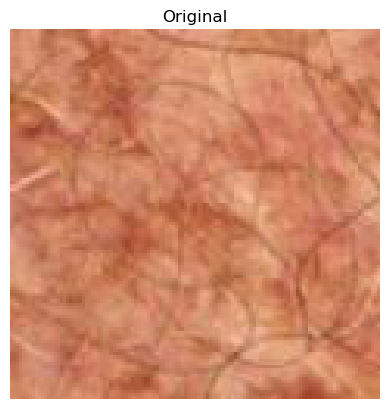

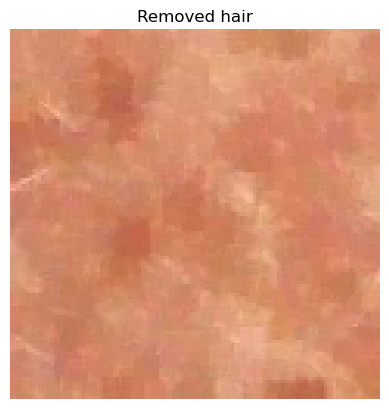

In [9]:
plt.imshow(np.array(test_images["ISIC_0015740"]))
plt.title('Original')
plt.axis('off')
plt.show()

plt.imshow(remove_hair(np.array(test_images["ISIC_0015740"])))
plt.title('Removed hair')
plt.axis('off')
plt.show()


## Dataset Class

Code to make dataset is from Eren's notebook: https://www.kaggle.com/code/metlnfoor/resnet34-removing-hair-under-sampling/notebook

In [10]:
class ISIC_2024(Dataset):
    def __init__(self,pil_images,metadata,transform=None,test=False):
        self.pil_images = pil_images
        self.metadata = metadata
        self.transform = transform
        self.test= test
        
    def __len__(self):
        return len(self.metadata)
    
    # This function from https://www.kaggle.com/competitions/isic-2024-challenge/discussion/519735
    def remove_hair(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
        blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)

        _, thresh = cv2.threshold(blackhat, 10 ,255, cv2.THRESH_BINARY)
        inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
        return inpainted_image
    
    def __getitem__(self,idx):
        isic_id = self.metadata.iloc[idx,0]
        cleaned_image = remove_hair(np.array(self.pil_images[isic_id]))
        image = Image.fromarray(cleaned_image)
        if self.transform:
            image = self.transform(image)
        if self.test:
            return image
        label = self.metadata.iloc[idx,-1]
        return image,label
    # def get_labels(self):
    #     return self.metadata["target"].values

In [11]:
train, val = train_test_split(X_sample,test_size=0.2,stratify=X_sample["target"])

## Get DataLoaders

In [12]:
"""
Define DataLoader Transforms
"""

train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),    
    transforms.RandomRotation(20),           
    transforms.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # commonly used mean and std calculated from ImageNet
])

test_transforms = transforms.Compose([
     transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # commonly used mean and std calculated from ImageNet
])

In [13]:
#init the dataset objects with the transforms
train_dataset = ISIC_2024(train_images, train, transform = train_transforms)
val_dataset = ISIC_2024(train_images, val, transform = test_transforms)
test_dataset = ISIC_2024(test_images, test_metadata, transform = test_transforms, test = True)

In [14]:
# make dataloaders now with ImbalancedDatasetSampler() for training but dont need for val and test loaders
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

## Define Model 1: ResNet152

In [15]:
class CustomResNet152(nn.Module):
    def __init__(self):
        super(CustomResNet152, self).__init__()
        # Load a pre-trained ResNet-152 model
        self.base_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
        
        # remove last fully connected layer for our purposes
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])

        # Classifier that includes flattening the feature map and linear layer for class prediction
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 1),  # output single value for prob calculation
            nn.Sigmoid()  # sigmoid activation for probability
        )
    
    def forward(self, x):
        # extract features
        x = self.features(x)
        # classify features
        output = self.classifier(x)
        return output

In [16]:
model1 = CustomResNet152()
model1 = model1.to(device)

## Define Criterion and Optimizer

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])


## Get Scheduler

In [17]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

scheduler = fetch_scheduler(optimizer)

## Training and Val Loop Function

In [25]:
def eval_or_train(model, dataloader, optimizer, criterion, device, mode = 'eval'):
    if mode == 'train':
        #init training mode
        model.train()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for data, target in tqdm(dataloader, desc="Train Loop"):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device).float()

            
            optimizer.zero_grad()
            #predict using input data
            curr_pred = model(data)
            #resize
            target = target.view(curr_pred.size())
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #backprop
            curr_loss.backward()
            #gradient descent step
            optimizer.step()

            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        

        train_avg_loss = epoch_total_loss / len(dataloader.dataset)
        train_auroc = binary_auroc(input=curr_pred.squeeze(), target=target.squeeze()).item()


        return train_avg_loss, train_auroc
    
    elif mode == 'eval':
        #init eval mode
        model.eval()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for data, target in tqdm(dataloader, desc="Eval Loop"):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device).float()

            #predict using input data
            curr_pred = model(data)

            #change the shape of target to match prediction
            target = target.view(curr_pred.size())
            
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #add to running loss and get prediction
            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            #get the number of correct preds and total preds
            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        eval_avg_loss = epoch_total_loss / len(dataloader.dataset)
        eval_auroc = binary_auroc(input=curr_pred.squeeze(), target=target.squeeze()).item()
        

        return eval_avg_loss, eval_auroc
    

## Training Loop

In [20]:
"""
Define EarlyStopping that will be used for training loop
"""

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

early_stopping = EarlyStopping(tolerance=5, min_delta=0)

In [21]:
torch.cuda.empty_cache()


In [22]:
"""
Run epochs with early stopping - RESNET152
"""
#init loss lists
train_loss_list = []
val_loss_list = []
train_auroc_list = []
val_auroc_list = []


#for checkpointing later
best_val_acc = 0  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model1, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_auroc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model1, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_auroc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model1.state_dict(), os.path.join(output_folder, f'res152_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train bin AUROC -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation bin AUROC -- ", val_acc, "; Validation loss -- ", val_loss)


Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch number: 1 / 40
      Train bin AUROC --  0.8611111111111112 ; Train loss --  0.7045327463798975
      Validation bin AUROC --  0.8881578947368421 ; Validation loss --  0.6666333609549017
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Epoch number: 2 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6353786097475763
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.6148494919376261
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]


Epoch number: 3 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6035088465293719
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.6047621369361877
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


Epoch number: 4 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.592557728055431
      Validation bin AUROC --  0.9276315789473685 ; Validation loss --  0.5941797486658867
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]


Epoch number: 5 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5823946575206177
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.5875593061748106
Epoch: 6


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]


Epoch number: 6 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5803482449031205
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.5863191306708597
Epoch: 7


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.08it/s]

We are at epoch: 7


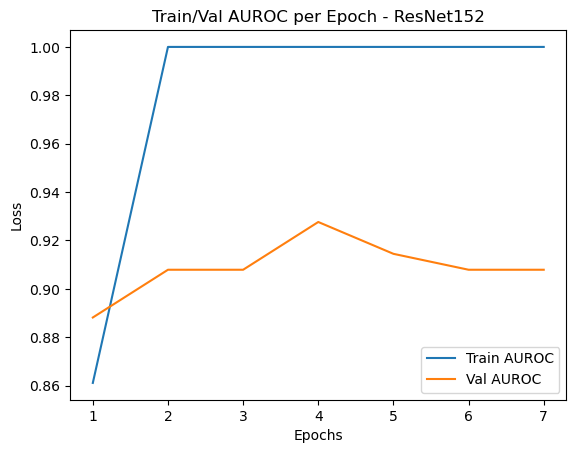

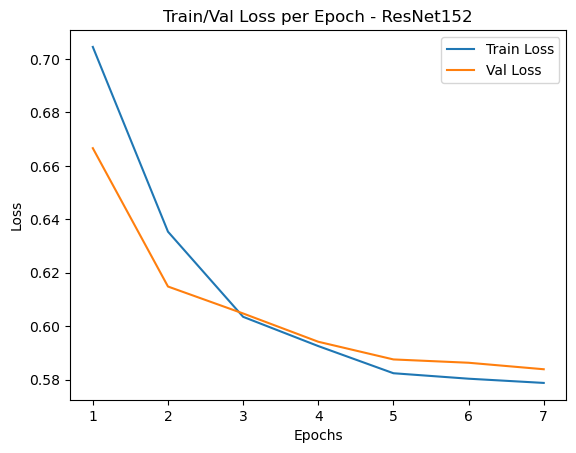

In [23]:
"""
Display losses of ResNet152:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), train_auroc_list, label = 'Train AUROC')
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), val_auroc_list, label = 'Val AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val AUROC per Epoch - ResNet152')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - ResNet152')
plt.legend()
plt.show()

## Define Model 2: ResNet50

In [24]:
"""
Setup second model (ResNet50), optimizer, criterion, scheduler, and early stopping
"""

class CustomResNet50(nn.Module):
    def __init__(self):
        super(CustomResNet50, self).__init__()
        # Load a pre-trained ResNet-152 model
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # remove last fully connected layer for our purposes
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])

        # Classifier that includes flattening the feature map and linear layer for class prediction
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 1),  # output single value for prob calculation
            nn.Sigmoid()  # sigmoid activation for probability
        )
    
    def forward(self, x):
        # extract features
        x = self.features(x)
        # classify features
        output = self.classifier(x)
        return output

model2 = CustomResNet50()
model2 = model2.to(device)


In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)
early_stopping = EarlyStopping(tolerance=5, min_delta=0)
torch.cuda.empty_cache()

In [26]:
"""
Run epochs with early stopping - RESNET50
"""
#init loss lists
train_loss_list = []
val_loss_list = []
train_auroc_list = []
val_auroc_list = []


#for checkpointing later
best_val_acc = 0  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model2, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_auroc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model2, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_auroc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2.state_dict(), os.path.join(output_folder, f'res50_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train bin AUROC -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation bin AUROC -- ", val_acc, "; Validation loss -- ", val_loss)

Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


Epoch number: 1 / 40
      Train bin AUROC --  0.9722222222222222 ; Train loss --  0.7092152856275645
      Validation bin AUROC --  0.8355263157894737 ; Validation loss --  0.6756325625103606
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


Epoch number: 2 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6418163294387758
      Validation bin AUROC --  0.8947368421052632 ; Validation loss --  0.6206999137791891
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


Epoch number: 3 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6071666220471233
      Validation bin AUROC --  0.9013157894736842 ; Validation loss --  0.6030529555249261
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Epoch number: 4 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5963091340055597
      Validation bin AUROC --  0.8947368421052632 ; Validation loss --  0.5972638702721755
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


Epoch number: 5 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5933247484869271
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.591814761213532
Epoch: 6


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


Epoch number: 6 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5851521925813348
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.5910449212589678
Epoch: 7


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Epoch number: 7 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5821083178651874
      Validation bin AUROC --  0.9342105263157895 ; Validation loss --  0.5904525293871261
Epoch: 8


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]


Epoch number: 8 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5798337581830147
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.5862164598480014
Epoch: 9


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]


We are at epoch: 9


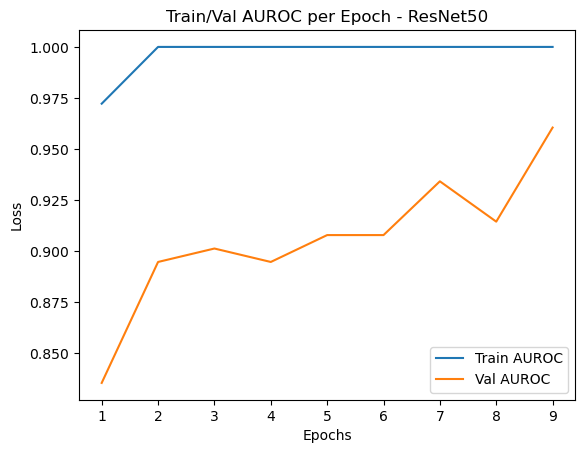

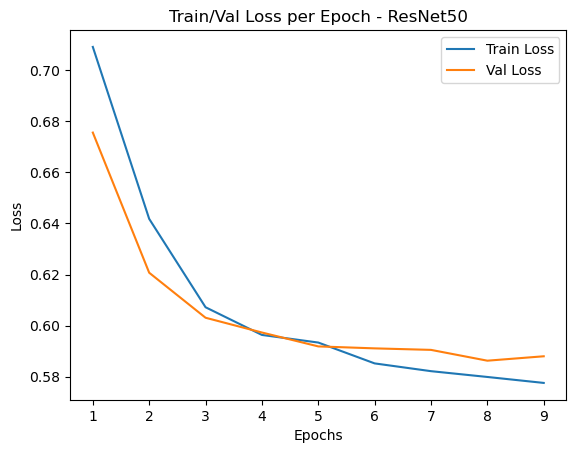

In [27]:
"""
Display losses of ResNet50:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), train_auroc_list, label = 'Train AUROC')
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), val_auroc_list, label = 'Val AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val AUROC per Epoch - ResNet50')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - ResNet50')
plt.legend()
plt.show()

## Define Model 3: MobileNetV2

In [28]:
class CustomMobileNetV2(nn.Module):
    def __init__(self):
        super(CustomMobileNetV2, self).__init__()
        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        
        self.features = self.base_model.features
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, 1),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [29]:
model3 = CustomMobileNetV2()
model3 = model3.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model3.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)
early_stopping = EarlyStopping(tolerance=5, min_delta=0)
torch.cuda.empty_cache()

In [30]:
"""
Run epochs with early stopping - MobileNetV2
"""
#init loss lists
train_loss_list = []
val_loss_list = []
train_auroc_list = []
val_auroc_list = []


#for checkpointing later
best_val_acc = 0  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model3, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_auroc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model3, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_auroc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model3.state_dict(), os.path.join(output_folder, f'mobileV2_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train bin AUROC -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation bin AUROC -- ", val_acc, "; Validation loss -- ", val_loss)

Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch number: 1 / 40
      Train bin AUROC --  0.8055555555555556 ; Train loss --  0.7412730342537693
      Validation bin AUROC --  0.7960526315789473 ; Validation loss --  0.7305171668411947
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch number: 2 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.7074250361388017
      Validation bin AUROC --  0.8421052631578947 ; Validation loss --  0.693998709115286
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.72it/s]


Epoch number: 3 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6783024688679321
      Validation bin AUROC --  0.868421052631579 ; Validation loss --  0.6611042838595087
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch number: 4 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6550527778132662
      Validation bin AUROC --  0.868421052631579 ; Validation loss --  0.639969546413986
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Epoch number: 5 / 40
      Train bin AUROC --  0.9166666666666666 ; Train loss --  0.6397355414001193
      Validation bin AUROC --  0.881578947368421 ; Validation loss --  0.6275336172218624
Epoch: 6


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch number: 6 / 40
      Train bin AUROC --  0.9722222222222222 ; Train loss --  0.6323798914867981
      Validation bin AUROC --  0.8881578947368421 ; Validation loss --  0.621528096570536
Epoch: 7


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s]


Epoch number: 7 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6236473569973451
      Validation bin AUROC --  0.9013157894736842 ; Validation loss --  0.612543585032401
Epoch: 8


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


Epoch number: 8 / 40
      Train bin AUROC --  0.9444444444444444 ; Train loss --  0.6143504017908897
      Validation bin AUROC --  0.8947368421052632 ; Validation loss --  0.6074445030157853
Epoch: 9


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Epoch number: 9 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6128108054693399
      Validation bin AUROC --  0.8881578947368421 ; Validation loss --  0.6047390296144128
Epoch: 10


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s]


Epoch number: 10 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.605894715828303
      Validation bin AUROC --  0.9013157894736842 ; Validation loss --  0.6042159341966377
Epoch: 11


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.04it/s]


Epoch number: 11 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6110214899042419
      Validation bin AUROC --  0.8947368421052632 ; Validation loss --  0.6012358886485504
Epoch: 12


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Epoch number: 12 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6038484058436557
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.5983932938801466
Epoch: 13


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.98it/s]


Epoch number: 13 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6017821616910148
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.5973597090154945
Epoch: 14


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s]


Epoch number: 14 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5985772595603085
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.5978836878046717
Epoch: 15


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s]


Epoch number: 15 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5972069933334516
      Validation bin AUROC --  0.881578947368421 ; Validation loss --  0.5993548186102797
Epoch: 16


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Epoch number: 16 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.598323942994225
      Validation bin AUROC --  0.8947368421052632 ; Validation loss --  0.5952764698974715
Epoch: 17


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Epoch number: 17 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5955494940868731
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.5950592682206419
Epoch: 18


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Epoch number: 18 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.597506449067381
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.5949389057516816
Epoch: 19


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch number: 19 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.595319867369221
      Validation bin AUROC --  0.9210526315789473 ; Validation loss --  0.5931708468252855
Epoch: 20


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]


Epoch number: 20 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5918155177340235
      Validation bin AUROC --  0.9210526315789473 ; Validation loss --  0.593272277471817
Epoch: 21


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Epoch number: 21 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5960208398585723
      Validation bin AUROC --  0.9342105263157895 ; Validation loss --  0.5905567589831305
Epoch: 22


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch number: 22 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5946174412084049
      Validation bin AUROC --  0.9013157894736842 ; Validation loss --  0.5904357442724164
Epoch: 23


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Epoch number: 23 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5916684940016481
      Validation bin AUROC --  0.9013157894736842 ; Validation loss --  0.5898802434434082
Epoch: 24


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Epoch number: 24 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.590638566299303
      Validation bin AUROC --  0.9013157894736842 ; Validation loss --  0.5894859272112273
Epoch: 25


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.57it/s]


Epoch number: 25 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5890987878720436
      Validation bin AUROC --  0.9078947368421053 ; Validation loss --  0.5914484351814616
Epoch: 26


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch number: 26 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.5874021692859115
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.5890001287827125
Epoch: 27


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]

We are at epoch: 27


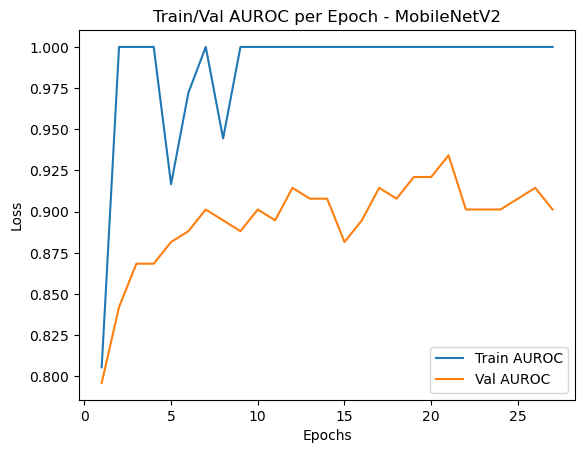

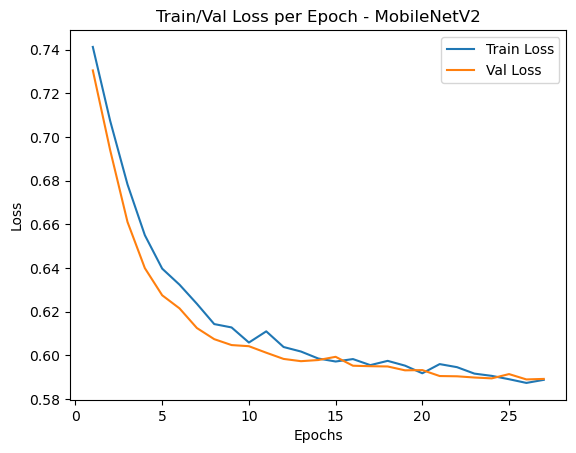

In [31]:
"""
Display losses of MobileNetV2:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), train_auroc_list, label = 'Train AUROC')
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), val_auroc_list, label = 'Val AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val AUROC per Epoch - MobileNetV2')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - MobileNetV2')
plt.legend()
plt.show()

## Define Model 4: MNASNet-1.0

In [32]:
class CustomMNASNet(nn.Module):
    def __init__(self):
        super(CustomMNASNet, self).__init__()
        self.base_model = models.mnasnet1_0(weights=models.MNASNet1_0_Weights.IMAGENET1K_V1)
        
        self.features = self.base_model.layers
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [33]:
model4 = CustomMNASNet()
model4 = model4.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model4.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)
early_stopping = EarlyStopping(tolerance=5, min_delta=0)
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to C:\Users\xusha/.cache\torch\hub\checkpoints\mnasnet1.0_top1_73.512-f206786ef8.pth
100%|██████████| 16.9M/16.9M [00:00<00:00, 65.6MB/s]


In [34]:
"""
Run epochs with early stopping - MNASNet-1.0
"""
#init loss lists
train_loss_list = []
val_loss_list = []
train_auroc_list = []
val_auroc_list = []


#for checkpointing later
best_val_acc = 0  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model4, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_auroc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model4, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_auroc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model4.state_dict(), os.path.join(output_folder, f'mnas1_0_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train bin AUROC -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation bin AUROC -- ", val_acc, "; Validation loss -- ", val_loss)

Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s]


Epoch number: 1 / 40
      Train bin AUROC --  0.7222222222222222 ; Train loss --  0.7352658585448707
      Validation bin AUROC --  0.48026315789473684 ; Validation loss --  0.736658718576563
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.06it/s]


Epoch number: 2 / 40
      Train bin AUROC --  0.4444444444444444 ; Train loss --  0.7275957059578078
      Validation bin AUROC --  0.46710526315789475 ; Validation loss --  0.7334855150659174
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


Epoch number: 3 / 40
      Train bin AUROC --  0.9166666666666666 ; Train loss --  0.7205605048399705
      Validation bin AUROC --  0.47368421052631576 ; Validation loss --  0.730078811005963
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s]


Epoch number: 4 / 40
      Train bin AUROC --  0.6388888888888888 ; Train loss --  0.7133287920284083
      Validation bin AUROC --  0.506578947368421 ; Validation loss --  0.7266487000726854
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


We are at epoch: 5


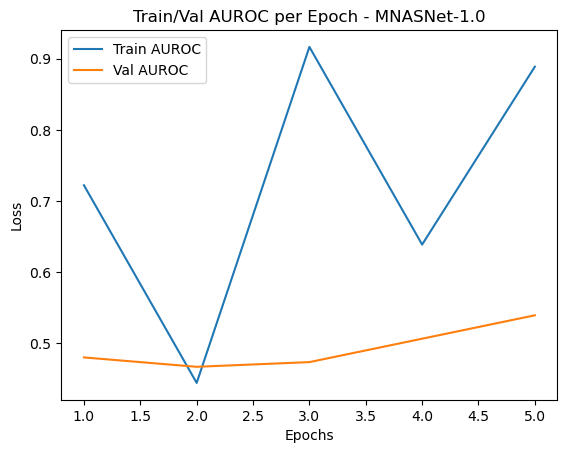

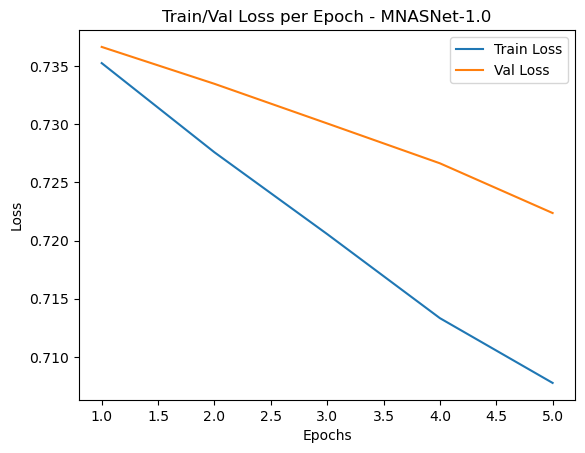

In [35]:
"""
Display losses of MNASNet-1.0:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), train_auroc_list, label = 'Train AUROC')
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), val_auroc_list, label = 'Val AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val AUROC per Epoch - MNASNet-1.0')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - MNASNet-1.0')
plt.legend()
plt.show()

## Define Model 5: EfficientNetB4

In [22]:
class CustomEfficientNetB4(nn.Module):
    def __init__(self):
        super(CustomEfficientNetB4, self).__init__()
        self.base_model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4), 
            nn.Linear(self.base_model.classifier[1].in_features, 1),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        output = self.base_model(x)
        return output

In [23]:
model5 = CustomEfficientNetB4()
model5 = model5.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model5.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)
early_stopping = EarlyStopping(tolerance=5, min_delta=0)
torch.cuda.empty_cache()

In [26]:
"""
Run epochs with early stopping - EfficientNetB4
"""
#init loss lists
train_loss_list = []
val_loss_list = []
train_auroc_list = []
val_auroc_list = []


#for checkpointing later
best_val_acc = 0  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model5, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_auroc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model5, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_auroc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model5.state_dict(), os.path.join(output_folder, f'effB4_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train bin AUROC -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation bin AUROC -- ", val_acc, "; Validation loss -- ", val_loss)

Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch number: 1 / 40
      Train bin AUROC --  0.4166666666666667 ; Train loss --  0.7354872425397238
      Validation bin AUROC --  0.3881578947368421 ; Validation loss --  0.7349792690672112
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]


Epoch number: 2 / 40
      Train bin AUROC --  0.3055555555555556 ; Train loss --  0.7331053671046827
      Validation bin AUROC --  0.4605263157894737 ; Validation loss --  0.7331749219631067
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Epoch number: 3 / 40
      Train bin AUROC --  0.7222222222222222 ; Train loss --  0.7299976722728572
      Validation bin AUROC --  0.5 ; Validation loss --  0.7308155081916373
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch number: 4 / 40
      Train bin AUROC --  0.6388888888888888 ; Train loss --  0.7276680650560579
      Validation bin AUROC --  0.5855263157894737 ; Validation loss --  0.7280335187676861
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch number: 5 / 40
      Train bin AUROC --  0.5555555555555556 ; Train loss --  0.7244709456225589
      Validation bin AUROC --  0.618421052631579 ; Validation loss --  0.7250234951399253
Epoch: 6


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


Epoch number: 6 / 40
      Train bin AUROC --  0.5277777777777778 ; Train loss --  0.722244973013387
      Validation bin AUROC --  0.6052631578947368 ; Validation loss --  0.7221873135726598
Epoch: 7


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

We are at epoch: 7


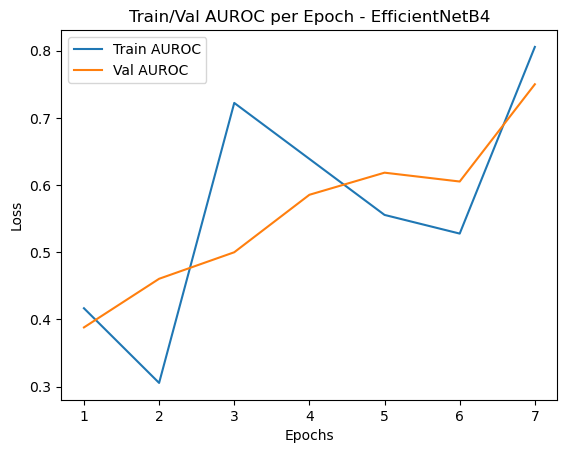

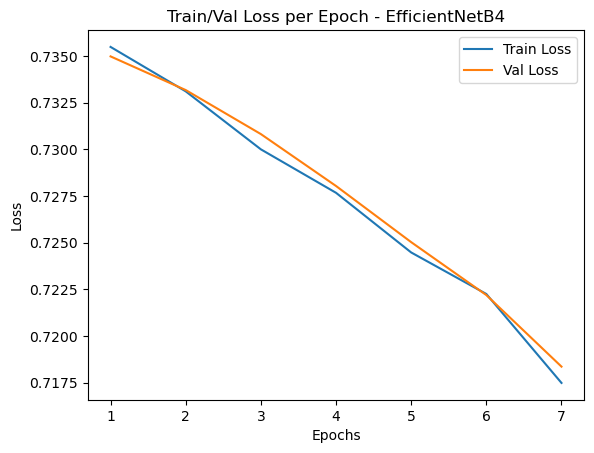

In [27]:
"""
Display losses of EfficientNetB4:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), train_auroc_list, label = 'Train AUROC')
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), val_auroc_list, label = 'Val AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val AUROC per Epoch - EfficientNetB4')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - EfficientNetB4')
plt.legend()
plt.show()

## Define Model 6: DenseNet121

In [28]:
class CustomDenseNet121(nn.Module):
    def __init__(self):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1024, 1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.base_model(x)
        return output

In [29]:
model6 = CustomDenseNet121()
model6 = model6.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model6.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)
early_stopping = EarlyStopping(tolerance=5, min_delta=0)
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\xusha/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 88.1MB/s]


In [30]:
"""
Run epochs with early stopping - DenseNet121
"""
#init loss lists
train_loss_list = []
val_loss_list = []
train_auroc_list = []
val_auroc_list = []


#for checkpointing later
best_val_acc = 0  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model6, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_auroc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model6, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_auroc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model6.state_dict(), os.path.join(output_folder, f'Dense121_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train bin AUROC -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation bin AUROC -- ", val_acc, "; Validation loss -- ", val_loss)

Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]


Epoch number: 1 / 40
      Train bin AUROC --  0.8888888888888888 ; Train loss --  0.7050700124198869
      Validation bin AUROC --  0.8355263157894737 ; Validation loss --  0.7185575559999816
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch number: 2 / 40
      Train bin AUROC --  0.9166666666666666 ; Train loss --  0.6756393727231073
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.6838826842797108
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch number: 3 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6462448900032796
      Validation bin AUROC --  0.9144736842105263 ; Validation loss --  0.652463476803646
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]


Epoch number: 4 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6318520523857553
      Validation bin AUROC --  0.9342105263157895 ; Validation loss --  0.6288274233863198
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


Epoch number: 5 / 40
      Train bin AUROC --  1.0 ; Train loss --  0.6175840281875882
      Validation bin AUROC --  0.9342105263157895 ; Validation loss --  0.618701242130889
Epoch: 6


Eval Loop: 100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


We are at epoch: 6


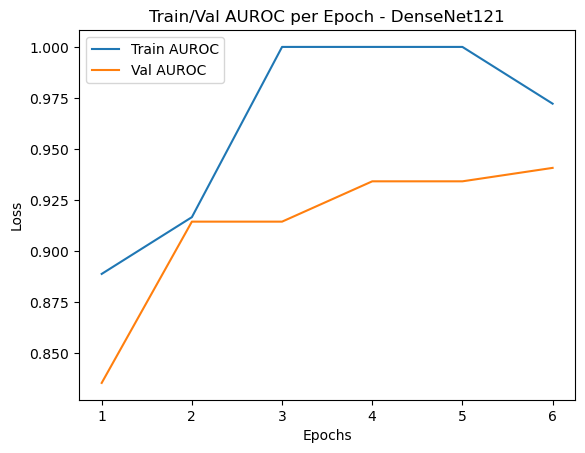

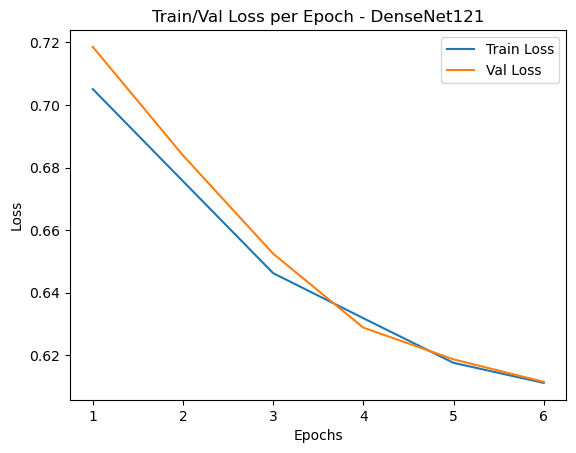

In [31]:
"""
Display losses of DenseNet121:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), train_auroc_list, label = 'Train AUROC')
plt.plot(np.linspace(1, len(train_auroc_list), len(train_auroc_list)), val_auroc_list, label = 'Val AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val AUROC per Epoch - DenseNet121')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - DenseNet121')
plt.legend()
plt.show()